# 第二模型训练（回归/分类）

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [47]:
# csv读取函数
def load_dataset(name):
    if name == "mitbih":
        train = pd.read_csv("../data/ecg_category/mitbih_train.csv", header=None)
        test = pd.read_csv("../data/ecg_category/mitbih_test.csv", header=None)
        X_train, y_train = train.iloc[:, :-1].values, train.iloc[:, -1].values.astype(int)
        X_test, y_test = test.iloc[:, :-1].values, test.iloc[:, -1].values.astype(int)
    elif name == "ptbdb":
        normal = pd.read_csv("../data/ecg_category/ptbdb_normal.csv", header=None)
        abnormal = pd.read_csv("../data/ecg_category/ptbdb_abnormal.csv", header=None)
        normal["label"] = 0
        abnormal["label"] = 1
        df = pd.concat([normal, abnormal], axis=0)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values.astype(int)
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    else:
        raise ValueError("Unknown dataset name")
    return X_train, X_test, y_train, y_test

In [48]:
# read data frame
# === 加载 MIT-BIH (5类) ===
mitbih_test = pd.read_csv("../data/ecg_category/mitbih_test.csv")
mitbih_train = pd.read_csv("../data/ecg_category/mitbih_train.csv")

X_mitbih_train, y_mitbih_train = mitbih_train.iloc[:, :-1].values, mitbih_train.iloc[:, -1].values
X_mitbih_test, y_mitbih_test = mitbih_test.iloc[:, :-1].values, mitbih_test.iloc[:, -1].values

In [49]:
# === 读取 PTBDB (只有特征) ===
ptbdb_normal = pd.read_csv("../data/ecg_category/ptbdb_normal.csv", header=None)
ptbdb_abnormal = pd.read_csv("../data/ecg_category/ptbdb_abnormal.csv", header=None)

# 给 normal 加标签 0
ptbdb_normal["label"] = 0
# 给 abnormal 加标签 1
ptbdb_abnormal["label"] = 1

# 合并
ptbdb = pd.concat([ptbdb_normal, ptbdb_abnormal], axis=0)

# 拆分特征和标签
X_ptbdb = ptbdb.iloc[:, :-1].values
y_ptbdb = ptbdb.iloc[:, -1].values.astype(int)

print("X_ptbdb shape:", X_ptbdb.shape)
print("y_ptbdb 分布:\n", pd.Series(y_ptbdb).value_counts())

X_ptbdb shape: (14552, 188)
y_ptbdb 分布:
 1    10506
0     4046
Name: count, dtype: int64


In [50]:
# === 检查标签分布 ===
print("训练集标签分布：")
print(pd.Series(y_mitbih_train).value_counts())

print("\n测试集标签分布：")
print(pd.Series(y_mitbih_test).value_counts())

# === 检查标签类型 ===
print("\ny_mitbih_train dtype:", y_mitbih_train.dtype)
print("y_mitbih_train unique values:", np.unique(y_mitbih_train)[:10])
print("y_mitbih_test unique values:", np.unique(y_mitbih_test)[:10])

# === 强制转 int，避免 float/NaN ===
y_mitbih_train = y_mitbih_train.astype(int)
y_mitbih_test = y_mitbih_test.astype(int)

训练集标签分布：
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

测试集标签分布：
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64

y_mitbih_train dtype: float64
y_mitbih_train unique values: [0. 1. 2. 3. 4.]
y_mitbih_test unique values: [0. 1. 2. 3. 4.]


In [51]:
from sklearn.utils import resample
import pandas as pd
import numpy as np

def make_per_class_balanced(X, y, target_per_class=2000, random_state=42):
    df = pd.DataFrame(X)
    df['label'] = y
    dfs = []
    for c in np.unique(y):
        cur = df[df.label == c]
        if len(cur) >= target_per_class:
            cur_bal = resample(cur, replace=False, n_samples=target_per_class, random_state=random_state)
        else:
            cur_bal = resample(cur, replace=True,  n_samples=target_per_class, random_state=random_state)
        dfs.append(cur_bal)
    df_bal = pd.concat(dfs, axis=0).sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    Xb = df_bal.drop('label', axis=1).values
    yb = df_bal['label'].values.astype(int)
    return Xb, yb

# 用它替换你现在的下采样逻辑
X_balanced, y_balanced = make_per_class_balanced(X_mitbih_train, y_mitbih_train, target_per_class=2000)

# 标准化（只fit训练数据）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_balanced = scaler.fit_transform(X_balanced)
X_test_std  = scaler.transform(X_mitbih_test)  # 评估时用


In [62]:
def per_beat_zscore(X):
    # X: (N, 188)
    m = X.mean(axis=1, keepdims=True)
    s = X.std(axis=1, keepdims=True) + 1e-8
    return (X - m) / s

X_balanced = per_beat_zscore(X_balanced)
X_test_std = per_beat_zscore(X_mitbih_test)   # 如果用样本内归一化，就别再用 StandardScaler


In [68]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# ======================
# 1. 采样平衡数据
# ======================
def make_balanced_dataset(X, y, max_samples_per_class=5000, random_state=42):
    X_balanced, y_balanced = [], []
    rng = np.random.RandomState(random_state)

    for label in np.unique(y):
        X_class = X[y == label]
        y_class = y[y == label]

        if len(X_class) > max_samples_per_class:
            idx = rng.choice(len(X_class), max_samples_per_class, replace=False)
            X_class = X_class[idx]
            y_class = y_class[idx]

        X_balanced.append(X_class)
        y_balanced.append(y_class)

    return np.vstack(X_balanced), np.concatenate(y_balanced)

X_balanced, y_balanced = make_balanced_dataset(X_mitbih_train, y_mitbih_train, max_samples_per_class=5000)

print("Balanced dataset:", X_balanced.shape, y_balanced.shape)
print("Class distribution:", np.bincount(y_balanced))

# ======================
# 2. 标准化
# ======================
def per_beat_zscore(X):
    m = X.mean(axis=1, keepdims=True)
    s = X.std(axis=1, keepdims=True) + 1e-8
    return (X - m) / s

X_balanced = per_beat_zscore(X_balanced)
X_test_std = per_beat_zscore(X_mitbih_test)

# CNN 输入要求 (N, steps, channels)
X_balanced = X_balanced[..., np.newaxis]  # (N, 187, 1)
X_test_std = X_test_std[..., np.newaxis]

print("X_balanced shape:", X_balanced.shape)
print("X_test_std shape:", X_test_std.shape)

# ======================
# 3. CNN 模型
# ======================
def build_cnn_ecg(input_length, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_length, 1)),

        layers.Conv1D(64, kernel_size=7, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(128, kernel_size=5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'),
        layers.GlobalAveragePooling1D(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

num_classes = len(np.unique(y_balanced))
model = build_cnn_ecg(X_balanced.shape[1], num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ======================
# 4. Train/Test split (1-fold)
# ======================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=256,
    verbose=1
)

# ======================
# 5. 测试集评估
# ======================
test_loss, test_acc = model.evaluate(X_test_std, y_mitbih_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")


Balanced dataset: (17864, 187) (17864,)
Class distribution: [5000 2223 5000  641 5000]
X_balanced shape: (17864, 187, 1)
X_test_std shape: (21891, 187, 1)
Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6035 - loss: 1.0153 - val_accuracy: 0.2799 - val_loss: 1.6683
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7918 - loss: 0.5902 - val_accuracy: 0.2799 - val_loss: 2.4960
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8393 - loss: 0.4810 - val_accuracy: 0.2799 - val_loss: 3.2982
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8610 - loss: 0.4083 - val_accuracy: 0.2799 - val_loss: 3.8405
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8817 - loss: 0.3577 - val_accuracy: 0.2799 - val_loss: 3.4836
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8882 - loss: 0.3340 - val_accuracy: 0.2804 - val_loss: 3.9860
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8991 - loss: 0.298

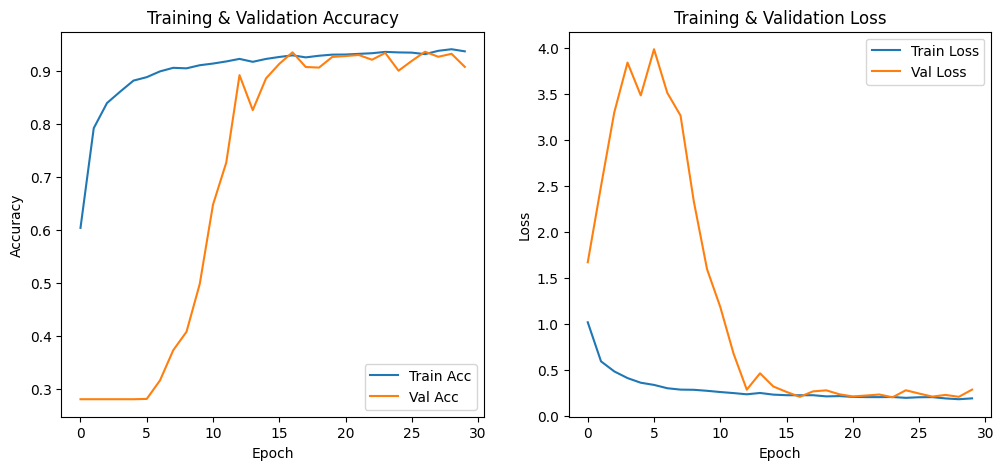

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


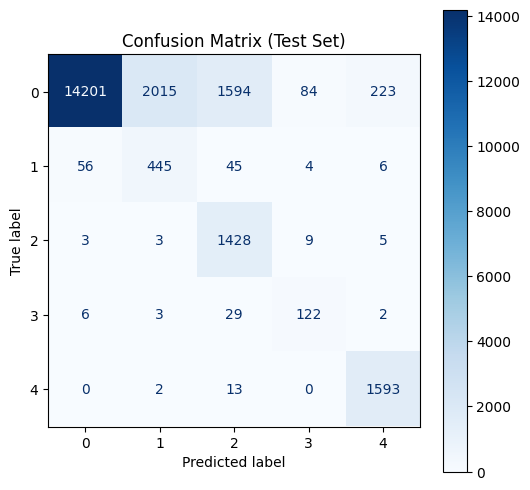

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ======================
# 1. 训练曲线
# ======================
plt.figure(figsize=(12, 5))

# Accuracy 曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Loss 曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

# ======================
# 2. 混淆矩阵
# ======================
y_pred = model.predict(X_test_std)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_mitbih_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_balanced))

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix (Test Set)")
plt.show()


Classification Report:
              precision    recall  f1-score       support
Class 0        0.995444  0.783849  0.877065  18117.000000
Class 1        0.180308  0.800360  0.294312    556.000000
Class 2        0.459312  0.986188  0.626728   1448.000000
Class 3        0.557078  0.753086  0.640420    162.000000
Class 4        0.870968  0.990672  0.926971   1608.000000
accuracy       0.812617  0.812617  0.812617      0.812617
macro avg      0.612622  0.862831  0.673099  21891.000000
weighted avg   0.926890  0.812617  0.847620  21891.000000


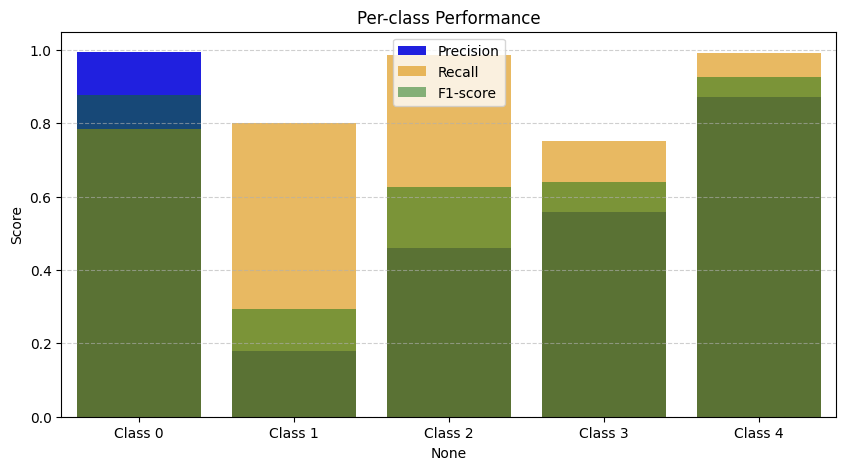

In [71]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

# 分类报告
report = classification_report(y_mitbih_test, y_pred_classes, target_names=[f"Class {i}" for i in np.unique(y_balanced)], output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("Classification Report:")
print(report_df)

# 可视化 Precision, Recall, F1
plt.figure(figsize=(10,5))
sns.barplot(x=report_df.index[:-3], y=report_df["precision"][:-3], color="blue", label="Precision")
sns.barplot(x=report_df.index[:-3], y=report_df["recall"][:-3], color="orange", label="Recall", alpha=0.7)
sns.barplot(x=report_df.index[:-3], y=report_df["f1-score"][:-3], color="green", label="F1-score", alpha=0.5)

plt.title("Per-class Performance")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.show()
